In [69]:
from synth_text_dataset import SynthTextCharactersDatasetTest
from transforms import char_transform, img_transform
import numpy as np

filename = 'Project/SynthText_train.h5'
model_name = 'all_models_with_perms\FontClassifierModel_0.01_50_CrossEntropyLoss_SGD_32_0.8_permutation'
num_of_images = 998
num_of_chars = 30520
init_shape = (100,100)

test_dataset = SynthTextCharactersDatasetTest(filename=filename, shape=init_shape, char_transform=char_transform, full_image_transform=img_transform)
permutation = np.loadtxt(rf'outputs\{model_name}.txt', dtype=int)

[85, 86, 87, 88, 89, 90, 91]
['>', 't', 'a', 'c', 'k', 'y', ',']


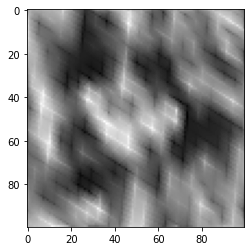

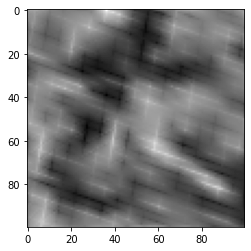

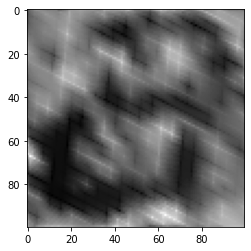

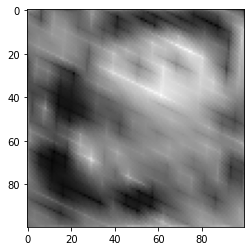

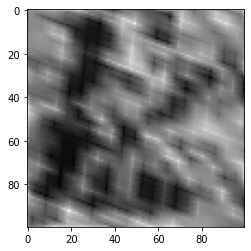

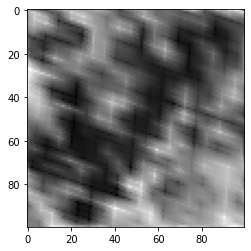

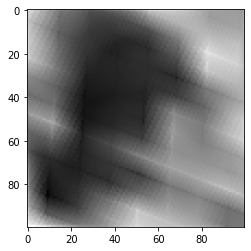

>
['>', 't', 'a', 'c', 'k', 'y', ',']
[85, 86, 87, 88, 89, 90, 91]


In [70]:
import matplotlib.pyplot as plt

# print(test_dataset.words)
# print(test_dataset.chars)

word_idx = 23
word = test_dataset.words[word_idx]
# print(test_dataset.x_items.shape)
# print(test_dataset.x_items[word].shape)

print(word)
print([test_dataset.chars[i] for i in word])
for char in test_dataset[word_idx]:
    plt.imshow(char[0], 'gray')
    plt.show()
    
print(test_dataset.get_char_at_idx(idx=word[0]))
print(test_dataset.get_chars_at_word_idx(word_idx=word_idx))
print(test_dataset.get_word_indexes_at_idx(word_idx=word_idx))

# for idx, word in enumerate(test_dataset):
#     print(f'{test_dataset.get_chars_at_word_idx(word_idx=idx)}, {word.shape = }')

In [81]:

import torch
from torch.utils.data import DataLoader
import numpy as np
from model import FontClassifierModel

model = FontClassifierModel(init_shape=init_shape, in_channels=1)
model.load_state_dict(torch.load(rf'models\{model_name}.pth'))
model.eval()

test_dataloader = DataLoader(test_dataset)
device = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
)
print(f'{device = }')

model.to(device)

y_pred = [None] * len(test_dataloader)
char_pred = np.zeros(len(test_dataset.chars))
char_pred_no_voting = np.zeros(len(test_dataset.chars))
with torch.no_grad():
    for idx, X in enumerate(test_dataloader):
        X = X.to(device)[0]
        curr_y_pred = model(X)
        # train_loss += loss_fn(pred, y.long()).item()
        # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        y_pred[idx] = curr_y_pred.argmax(dim=1)
        curr_char_pred = np.bincount(y_pred[idx].cpu()).argmax()
        for char_i, i in enumerate(test_dataset.get_word_indexes_at_idx(idx)):
            char_pred[i] = curr_char_pred
            char_pred_no_voting[i] = y_pred[idx][char_i]


device = device(type='cuda', index=0)


In [82]:
from synth_text_dataset import SynthTextCharactersDatasetRAM
from transforms import img_transform, char_transform, labels_transform

init_shape = (100,100)

test_dataset_ram = SynthTextCharactersDatasetRAM(
    filename,
    full_image_transform=img_transform,
    on_get_item_transform=char_transform,
    target_transform=labels_transform,
    shape=init_shape,
)

y_actual = test_dataset_ram.y_items

In [84]:
start_idx = int(0.8 * num_of_chars)

char_pred_test = char_pred[permutation][start_idx:]
y_actual_test = y_actual[permutation][start_idx:]
char_pred_no_voting_test = char_pred_no_voting[permutation][start_idx:]

print('Test stats:')
print(f'With voting accuracy: {(char_pred_test.astype(int) == y_actual_test.astype(int)).astype(int).sum() * 100 / len(y_actual_test)}')
print(f'Without voting accuracy: {(char_pred_no_voting_test.astype(int) == y_actual_test.astype(int)).astype(int).sum() * 100 / len(y_actual_test)}')

char_pred_train = char_pred[permutation][:start_idx]
y_actual_train = y_actual[permutation][:start_idx]
char_pred_no_voting_train = char_pred_no_voting[permutation][:start_idx]

print('Train stats:')
print(f'With voting accuracy: {(char_pred_train.astype(int) == y_actual_train.astype(int)).astype(int).sum() * 100 / len(y_actual_train)}')
print(f'Without voting accuracy: {(char_pred_no_voting_train.astype(int) == y_actual_train.astype(int)).astype(int).sum() * 100 / len(y_actual_train)}')

Test stats:
With voting accuracy: 93.11926605504587
Without voting accuracy: 81.32372214941022
Train stats:
With voting accuracy: 94.64285714285714
Without voting accuracy: 89.46182830930537


In [80]:
char_pred

2.0